<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture #16

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import numpy.matlib as ml

##In our last episode

* Newton's method in multiple dimensions
  * Strengths of Newton's method (quick convergence when close to minimum)
  * Weakness of Newton's method (may fly out of control if not close)
* Brief comments on Levenberg-Marquardt
* Other quasi-Newton methods: 
  * Use $\mathbb{A}$ in place of $\mathbb{H}^{-1}$
  * Start with $\mathbb{A}=\mathbb{I}$ to head "downhill"
  * Iteratively update $\mathbb{A}$ to estimate $\mathbb{H}^{-1}$
  * BFGS = popular updating scheme. Available in `scipy.optimize.minimize`

# Numerical Integration

## Trapezoid Rule

The trapezoid rule reads $\int_a^b f(x) dx \approx h(\frac{1}{2}f(a)+ \frac{1}{2}f(b))$ where $h=b-a$ is the length of the interval. Its name comes from the shape of the area being summed up.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="200">

Unfortunately, it should be clear that evaluating at only two points will not be sufficient.

##Extended Trapezoid Rule

The extended trapezoid rule just divides the interval $[a,b]$ into N sub-intervals and then employs the trapezoid rule in each:

$$ \int_a^b f(x) dx \approx h \left[ \frac{1}{2}f(x_0)+ f(x_1) + f(x_2) + \ldots + f(x_{N-1}) + \frac{1}{2}f(x_{N}) \right ] $$

Where $h = (b-a)/N$ is the length of each sub-interval, $x_0 = a$, and $x_N = b$.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="100"><img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="100"><img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="100"><img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="100"><img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="100">


<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Integration_rectangle.svg" width="500">


##Quadrature

_Quadrature_, in the general sense, just refers to any scheme for figuring out the area of a region. In our class, we are referring more specifically to an algorithm which divides the interval $[a,b]$ into equal length subintervals, computes the area, and iterates, continuing to subdivide until a convergence criterion is reached.



###The `quad` algorithm

The figure below shows a function $f(x)$ on the interval $[a,b]$. We'll describe the first four stages of a quadrature algorithm that uses the extended trapezoid rule iteratively. We'll see how we can carefully reuse the computations of previous stages, so as to do as little work as possible. Then, we'll generalize what we've learned into an algorithm that will work for $N$ stages and establish some convergence criteria that will terminate the algorithm and return the estimated integral.

We'll write the estimate of the integral at each stage as $I_i$.

__Stage 1__

$I_1 = h_1 \left [ \frac{1}{2} f_0 + \frac{1}{2} f_8 \right] $  with $f_i = f(x_i)$ and $h_1=(b-a)$

__Stage 2__

$I_2 = h_2 \left [\frac{1}{2} f_0 + f_4 + \frac{1}{2} f_8 \right] $ with $h_2=(b-a)/2$

We can rearrange terms to show that $I_2 = \frac{1}{2} I_1 + h_2 f_4$, and therefore we only need to evaluate the function at $x_4$. This would be important if our function was expensive to evaluate and/or we were integrating a large number of functions as quickly as possible.

__Stage 3__

$I_3 = h_3 \left [  \frac{1}{2} f_0 + f_2 + f_4 + f_6 + \frac{1}{2} f_8 \right]$ with $h_3=(b-a)/4 = (b-a)/2^{3-1}$

We can rearrange terms to show that $I_3 = \frac{1}{2} I_2 + h_3 \left[f_2 + f_6 \right]$ and we again reuse the results of the previous stage.

__Stage 4__

$I_4 = h_4 \left [  \frac{1}{2} f_0 + f_1 + f_2 + f_3 + f_4 + f_5 + f_6 + f_7 + \frac{1}{2} f_8 \right]$ with $h_4=(b-a)/8 = (b-a)/2^{4-1}$

Again, rearranging terms shows $I_4 = \frac{1}{2} I_3 + h_4 \left [ f_1 + f_3 + f_5 + f_7 \right]$


__Generalizing__

1. We start at stage $n = 1$ with: $I_1 = (b-a) \left[ \frac{1}{2} f_a + \frac{1}{2} f_b \right] $

2. At each stage $n > 1$ we divide the interval into sub-intervals of length $h_n = (b-a)/2^{n-1}$.

3. We add $2^{n-2}$ new points starting with a point at $x_0 + h_n/2$ and then continuing in steps of $h_n$. 

4. We evaluate the function at the new points and sum.

5. The new estimate of the integral is $I_n = \frac{1}{2} I_{n-1} + h_n \left [ \mbox{sum of new} ~f_i \right]$

6. We compare $|I_n - I_{n-1}|$ to $I_{n-1}$ multiplied by some fractional accuraccy and quit when the difference is small enough. We also compare $|I_n|$ and $|I_{n-1}|$ to an absolute accuracy and quit when they are smaller. The last step is needed for integrals that evaluate to zero or a value close to zero.

In [0]:
def quad(f, a, b, facc = 1e-6, abacc = 1e-10, nmax = 25, debug = False):
    ''' integrate f(x) on the interval [a,b]
    
        iterate until the fractional difference between succesive calls is
        less than facc or the absolute difference < abacc
        or until nmax iterations
    '''
    # stage 1
    h = (b - a)
    Iold = 0.5*(f(b) + f(a))
    for nstage in range(2, nmax+1):
        if debug: print("nstage=", nstage)
        h = (b - a) / 2**(nstage-1)
        xnew = a + h # first new point
        Iupdate = f(xnew)
        for inew in range(1, 2**(nstage-2)): # adding additional new points
            xnew += 2*h
            Iupdate += f(xnew)
        Iupdate *= h
        Inew = 0.5*Iold + Iupdate # new value of the integral
        if debug: print(Iold, Iupdate, Inew, Iold - Inew, facc * math.fabs(Iold))
        # now check for convergence

        if math.fabs(Inew - Iold) < facc * math.fabs(Iold) \
        or (math.fabs(Inew) < abacc and math.fabs(Iold) < abacc):
            return Inew, nstage
        Iold = Inew
        

### Example: $f_1(x) = e^{-x}$

$$ \int_0^1 f_1(x) dx = \int_0^1 e^{-x} dx = -e^{-x} \big|_0^1 = -e^{-1} + 1 $$

Calculated result = 0.6321207597742593 in n = 10
Correct result = 0.6321205588285577


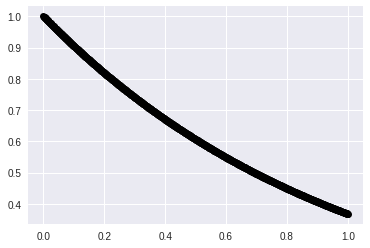

In [0]:
f1 = lambda x: np.exp(-x)
I, n = quad(f1, 0, 1)

x = np.linspace(0, 1, 2**n)
plt.plot(x, f1(x), 'ok')
print("Calculated result =", I, "in n =", n)
print("Correct result =", 1 - math.e**(-1))

### Example:  $f_2(x) = \sin\pi x$

$$ \int_0^1 f_2(x) dx = \int_0^1 \sin \pi x dx = -\frac{1}{\pi} \cos \pi x \big|_0^1 = \frac{2}{\pi} $$

Calculated result = 0.6366196475318998 in n = 12
Correct result = 0.6366197723675814


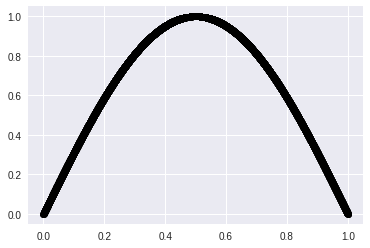

In [0]:
f2 = lambda x : np.sin(math.pi*x)
I, n = quad(f2, 0, 1)

x = np.linspace(0, 1, 2**n)
plt.plot(x, f2(x), 'ok')
print("Calculated result =", I, "in n =", n)
print("Correct result =", 1/math.pi * (np.cos(0) - np.cos(math.pi)))

### Example: heat capacity

$$ C_V = 9 N k \, g(u) $$
where
$$ g(u) = u^3 \int_0^{1/u} \frac{x^4 e^x}{(e^x - 1)^2} dx $$
and $N$ the number of particles in the solid, $k = 1.38 \times 10^{-23}\,$J/K the Boltzman constant, $u = T/T_D$, $T$ the absolute temperature, and $T_D$ the Debye temperature. E.g. $T_D(\mbox{Cu}) = 343$ K

Plot the heat capacity as a function of temperature.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/54/DebyeVSEinstein.jpg" width="500">

In [0]:
integrand = lambda x: x**4 * np.exp(x) / (np.exp(x) - 1)**2

def CV(ulist, xmin = 1e-6):
  return [3 * u**3 * quad(integrand, xmin, 1.0 / u)[0] for u in ulist]

u = np.linspace(0.1, 1.5, 14)
plt.plot(u, CV(u))

NameError: ignored

##Using scipy's routine

In [0]:
import scipy.integrate as ig

In [0]:
ig.quad(f1, 0, 1, full_output = False)

(0.6321205588285578, 7.017947987503856e-15)

##One weird trick to improve `quad`

At each stage of the `quad` routine we are computing the integral via extended quadrature:

$$ \int_a^b f(x) dx \approx h_N \left[ \frac{1}{2}f(x_0)+ f(x_1) + f(x_2) + \ldots + f(x_{N-1}) + \frac{1}{2}f(x_{N}) \right ] $$

It turns out, mathematicians have proven that:

$$ \int_a^b f(x) dx = h_N \left[ \frac{1}{2}f(x_0)+ f(x_1) + f(x_2) + \ldots + f(x_{N-1}) + \frac{1}{2}f(x_{N}) \right]  - \frac{B_2 h_N^2}{2!} (f'(b) - f'(a)) + \mbox{higher order terms in}~h_N $$


With the _Bernoulli number_ $B_2=\frac{1}{6}$. This is the _Euler-Maclaurin summation formula_.

Now, imagine we compute 

$$I_N = h_N \left[ \frac{1}{2}f(x_0)+ f(x_1) + f(x_2) + \ldots + f(x_{N-1}) + \frac{1}{2}f(x_{N}) \right] = \int_a^b f(x) dx + \frac{B_2 h_N^2}{2!} (f'(b) - f'(a)]+ \mbox{h.o.t.} $$

The first equality is due to our definition of $I_N$. The second is due to the Euler-Maclaurin formula.

Then, we compute $I_{N+1}$

$$I_{N+1} = h_N \left[ \frac{1}{2}f(x_0)+ f(x_1) + f(x_2) + \ldots + f(x_{N}) + \frac{1}{2}f(x_{N+1}) \right] = \int_a^b f(x) dx + \frac{B_2 h_{N+1}^2}{2!} (f'(b) - f'(a)) + \mbox{h.o.t.} $$

But, $h_{N+1} = h_N/2$ so

$$I_{N+1} = \int_a^b f(x) dx + \frac{1}{4}\frac{B_2 h_{N}^2}{2!} (f'(b) - f'(a)) + \mbox{h.o.t.}$$

Therefore, if we can form a better estimate for the integral:

$$I = \frac{1}{3} \left[ 4I_{N+1} - I_N \right] = \int_a^b f(x) dx + \mbox{h.o.t.}$$

This cancels out the effect of the first order correction in the Euler-Maclaurin summation formula and it's 100% free since at stage $N+1$ we've already computed $I_N$ and $I_{N+1}$.  This simple correction can result in 1-2 orders of magnitude fewer function calls when evaluating an integral. 

Note: at stage N the number of function calls is $1+2^{N-1}$. For example, with this trick, we go from needing 10 stages needed to evaluate `f1` (513 points) to 6 stages (37). Pretty impressive!

In [0]:
def quad2(f, a, b, facc = 1e-6, abacc = 1e-10, nmax = 24):
    ''' integrate the function f(x) on the interval [a,b]
    
        iterate until the fractional difference between successive calls is
        less than facc, the absolute difference is less than abacc
        or until nmax iterations have been reached.
        
    '''
    # stage 1
    h = (b - a)
    Iold = 0.5*(f(b) + f(a))
    Icorrold = 0.0
    for nstage in range(2, nmax+1):
        print("nstage =", nstage)
        h = (b - a) / 2**(nstage-1)
        xnew = a + h
        Iupdate = f(xnew)
        for inew in range(1, 2**(nstage-2)):
            xnew += 2*h
            Iupdate += f(xnew)
        Iupdate *= h
        Inew = 0.5*Iold + Iupdate
        Icorr = (4.0*Inew - Iold)/3.0
        print(Iold, Iupdate, Inew, Icorr, Inew-Iold, facc*math.fabs(Iold))
        if math.fabs(Icorr - Icorrold) < facc*math.fabs(Icorrold) \
        or (math.fabs(Icorr) < abacc and math.fabs(Icorrold) < abacc):
            return Icorr, nstage
        Iold = Inew
        Icorrold = Icorr

nstage = 2
0.6839397205857212 0.3032653298563167 0.6452351901491773 0.6323336800036626 -0.03870453043654387 6.839397205857212e-07
nstage = 3
0.6452351901491773 0.3127918339531049 0.6354094290276935 0.6321341753205322 -0.009825761121483811 6.452351901491773e-07
nstage = 4
0.6354094290276935 0.31523870369663326 0.6329434182104801 0.6321214146047422 -0.0024660108172134265 6.354094290276934e-07
nstage = 5
0.6329434182104801 0.3158546047392595 0.6323263138444996 0.6321206123891727 -0.0006171043659805031 6.3294341821048e-07
nstage = 6
0.6323263138444996 0.31600884317182276 0.6321720000940725 0.6321205621772634 -0.00015431375042707085 6.323263138444995e-07
Calculated result = 0.6321205621772634 in n = 6
Correct result = 0.6321205588285577


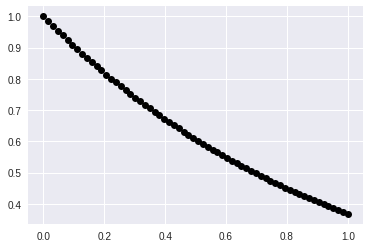

In [0]:
I, n = quad2(f1, 0, 1)

x = np.linspace(0, 1, 2**n)
plt.plot(x, f1(x), 'ok')
print("Calculated result =", I, "in n =", n)
print("Correct result =", 1 - math.e**(-1))

nstage = 2
6.123233995736766e-17 0.5 0.5 0.6666666666666666 0.49999999999999994 6.123233995736766e-23
nstage = 3
0.5 0.35355339059327373 0.6035533905932737 0.6380711874576983 0.10355339059327373 5e-07
nstage = 4
0.6035533905932737 0.3266407412190942 0.6284174365157311 0.6367054518232169 0.02486404592245739 6.035533905932737e-07
nstage = 5
0.6284174365157311 0.3203644309676883 0.6345731492255539 0.6366250534621615 0.006155712709822736 6.284174365157311e-07
nstage = 6
0.6345731492255539 0.3188217886680727 0.6361083632808496 0.6366201012992816 0.001535214055295775 6.345731492255538e-07
nstage = 7
0.6361083632808496 0.3184377538608767 0.6364919355013015 0.6366197929081188 0.00038357222045182215 6.361083632808496e-07
Calculated result = 0.6366197929081188 in n = 7
Correct result = 0.6366197723675814


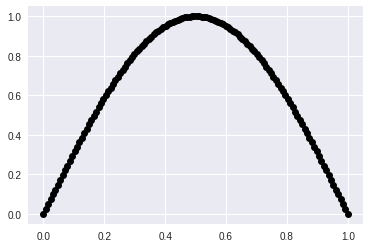

In [0]:
I, n = quad2(f2, 0, 1)

x = np.linspace(0, 1, 2**n)
plt.plot(x, f2(x), 'ok')
print("Calculated result =", I, "in n =", n)
print("Correct result =", 1/math.pi * (np.cos(0) - np.cos(math.pi)))

In [0]:
2**7


128